# 0. Import

In [1]:
import numpy  as np
import pandas as pd
from   scipy.interpolate import interp1d
from   scipy.interpolate import interp2d
from   scipy.misc import derivative
from   scipy import optimize
import astropy.units as u
#import astropy.constants as c
from   astropy.cosmology import FlatLambdaCDM, z_at_value
from   tqdm import *
from   sympy import *
from   astropy.cosmology import Planck13 as cosmo
from   astropy import constants as const
import sys
from   scipy.interpolate import interp1d
from   scipy.interpolate import interp2d
from   scipy.special import zeta
import pickle

import matplotlib.pyplot as plt
from   matplotlib import ticker
from matplotlib import gridspec
import matplotlib.pylab as pylab
import units
import time

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

#suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Plot parameters
from plot_params import params

pylab.rcParams.update(params)

cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
# From https://stackoverflow.com/questions/37765197/darken-or-lighten-a-color-in-matplotlib
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

# 1. Definitions of constants and functions

## 1A. Constants and Functions (General)

Hydrogen number density

\begin{equation}
n_\text{H} = (1-Y_p) n_b = (1-Y_p) \times \eta \frac{2 \zeta(3)}{\pi^2} T^3_\gamma,
\end{equation}

Proton number density (proton from both Hydrogen and Helium)

\begin{equation}
n_p = \left( 1 - \frac{Y_p}{2} \right) n_b = \left( 1 - \frac{Y_p}{2} \right) \times \eta \frac{2 \zeta(3)}{\pi^2} T^3. 
\end{equation}

In [4]:
# From Andrea       # H0      = 1.43654e-33 # in eV
# From Andrea       # Omega_m = 0.3165
# From Andrea       # Omega_r = 8e-5
# From Andrea       # ne0     = (1 - 0.25/2)*2.46e-7 # in cm^-3
# From Andrea       # TCMB_0  = 2.3482e-4    # in eV

# From Xucheng MMA  # TCMB_0  = 2.725*K    # in eV
# From Xucheng MMA  # Omega_m = 0.31684
# From Xucheng MMA  # eta = 6.16 * 10**(-10)


# Fundamental Constants
h = 4.135667696*1e-15          # in eV s

hbar = h / (2*np.pi)           # in eV s

c = 2.99792458*1e10            # in cm/s

mpl = 1.2209 * 10**19 * 10**9  # in eV

# Defined by Xucheng

# Consistent with my MMA
cm_to_m     = 10**(-2)
cm_to_km    = 10**(-5)

m_to_cm     = 1/cm_to_m
km_to_cm    = 1/cm_to_km

pc_to_cm    = 3.08567758149137* 10**18
Mpc_to_cm   = 10**6 * pc_to_cm

cmInv_to_eV = hbar*c
sInv_to_eV  = hbar
eV_to_J     = 1.602176634 * 10**(-19)
kB_to_JperK = 1.38064852 * 10**(-23)

eV_to_K = eV_to_J/kB_to_JperK

J = 1/eV_to_J  # in eV
K = 1/eV_to_K  # in eV

# Cosmological Constants

# Planck 2018 paper VI Table 2 Final column (68% confidence interval)
planck18_cosmology = {'Oc0': 0.2607,
                              'Ob0': 0.04897,
                              'Om0': 0.3111,
                              'Hubble0': 67.66,
                              'n': 0.9665,
                              'sigma8': 0.8102,
                              'tau': 0.0561,
                              'z_reion': 7.82,
                              't0': 13.787,
                              'Tcmb0': 2.7255,
                              'Neff': 3.046,
                              'm_nu': [0., 0., 0.06],
                              'z_recomb': 1089.80,
                              'reference': "Planck 2018 results. VI. Cosmological Parameters, "
                                           "A&A, submitted, Table 2 (TT, TE, EE + lowE + lensing + BAO)"
                              }


# TCMB_0 from Planck 2018
TCMB_0   = planck18_cosmology["Tcmb0"]*K # in eV


# H = h_Hubble * 100 km/s/Mpc
# Note: 'h' is already used for Planck constant before
h_Hubble = planck18_cosmology["Hubble0"]/100

H0       = h_Hubble * ( 100 * km_to_cm * sInv_to_eV/ Mpc_to_cm )   # in eV

# Faction of matter
Omega_m  = planck18_cosmology["Om0"]

# Fraction of radiation
Omega_r = (8*np.pi**3/90) * 3.38 * (TCMB_0**4/(mpl**2 * H0**2))

# Fraction of dark energy
Omega_Lambda = 1 - Omega_r - Omega_m

# Baryon-to-photon ratio, from 1912.01132
eta = 6.129 * 10**(-10)

# Helium-to-hydrogen mass fraction, from 1912.01132
Yp  = 0.247

# Electron mass (from PDG)
m_e = 0.511 * 10**6 # in eV

# From PDG
alpha = 1/137.035999084

ee = np.sqrt(4*np.pi*alpha)

# Thompson Scattering Cross Section (Double-checked with Wiki)
thomson_xsec = 6.6524587158e-25   # cm^2

# electron’s Compton wavelength (Double-checked with Wiki)
# lambda_e = 2.426e-10  cm
lambda_e = (2*np.pi/m_e)*cmInv_to_eV # in cm

# red shift for mu-y transition era [z_trans_1, z_trans_2]
z_trans_1 = 10**4
z_trans_2 = 3 * 10**5

# Hubble Parameter
# in eV
def hubble(z):
    
    return H0 * np.sqrt(Omega_Lambda + Omega_m * (1.0 + z) ** 3 + Omega_r * (1.0 + z) ** 4)

# n_p function [cm^-3]
def n_p(z):
    
    n_p_0 = (1-Yp/2) * eta * (2*zeta(3)/np.pi**2) * ( TCMB_0 / cmInv_to_eV )**3   # in cm^-3
    
    n_p_z = n_p_0 * (1+z)**3   # in cm^-3
    
    return n_p_z


# n_H function [cm^-3]
def n_H(z):
    
    n_H_0 = (1-Yp) * eta * (2*zeta(3)/np.pi**2) * ( TCMB_0 / cmInv_to_eV )**3   # in cm^-3
    
    n_H_z = n_H_0 * (1+z)**3   # in cm^-3
    
    return n_H_z



# ========================================================
# x_e function defined by Andrea
# ========================================================

x_e_data = pickle.load(open("std_soln_He.p", "rb"))

def x_e(z):
    
    return np.interp(z, np.flipud(x_e_data[0]) - 1.0, np.flipud(x_e_data[2]))

## 1B. Exact $X_e$

Free electron fraction (total)

$X_e = \frac{n_{e}}{n_\text{H}} = \frac{ n_{e,\text{H}} + n_{e,\text{He}} }{ n_\text{H} }$ 

Free electron fraction (from Hydrogen)

$X_{e,\text{H}} = \frac{n_{e,\text{H}}}{n_\text{H}}$

In [5]:
# Parameters used in Class
class_parameters = {'H0':         planck18_cosmology["Hubble0"],
                    'Omega_b':    planck18_cosmology["Ob0"],
                    'N_ur':       planck18_cosmology["Neff"],
                    'Omega_cdm':  planck18_cosmology["Oc0"],
                    'YHe':        Yp,
                    'z_reio':     planck18_cosmology["z_reion"]}

# Call class
from classy import Class

CLASS_inst = Class()
CLASS_inst.set(class_parameters)
CLASS_inst.compute()

# z array
z_ary_log     = np.logspace(-6, 8, 100000)
# z_ary_log     = np.logspace(-6, 8, 300000)


# Add 0(today) at the beginning of z_ary
z_ary = np.insert(z_ary_log,0,[0])

# Xe array
Xe_ary   = np.array([ CLASS_inst.ionization_fraction(z) for z in z_ary ])

# XeH array
# (If Xe>=1, replace it with 1)
XeH_ary = np.where(Xe_ary<=1,Xe_ary,1)

# Xe interpolation
Xe_interp  = interp1d(z_ary, Xe_ary, fill_value="extrapolate")

# XeH interpolation
XeH_interp = interp1d(z_ary, XeH_ary, fill_value="extrapolate")

# dXe/dz array
# (with the length of z_ary[:-1])
dXe_dz_ary = np.diff(Xe_ary)/np.diff(z_ary)

# dXeH/dz array
# (with the length of z_ary[:-1])
dXeH_dz_ary = np.diff(XeH_ary)/np.diff(z_ary)


# dXe/dz interpolation
dXe_dz_interp  = interp1d(z_ary[:-1], dXe_dz_ary, fill_value="extrapolate")

# # dXeH/dz interpolation
dXeH_dz_interp  = interp1d(z_ary[:-1],  dXeH_dz_ary, fill_value="extrapolate")



# n_e function [cm^-3]
def n_e(z):
    
    n_e_z = Xe_interp(z) * n_H(z)
    
    return n_e_z   # in cm^-3

ne0 = n_e(0)

# mA^2 at z=0
mASq0 = ee**2 * (ne0 * cmInv_to_eV**3)/m_e  # in eV^2

## 1C. Constants and Functions (Special)

$\alpha_\rho= \frac{\zeta(3)}{3 \zeta(4)} \simeq 0.3702$

$\alpha_\mu = \frac{\zeta(2)}{3\zeta(3)}  \simeq 0.456$

$x_0 = \frac{4}{3 \alpha_\rho} = \frac{4\zeta(4)}{\zeta(3)} \simeq 3.6$

$\kappa_c = \frac{45}{\pi^4} \left( \frac{2 \pi^6}{ 135 \zeta(3) } - 6 \zeta(3) \right) \simeq 2.14185$

$\rho_\gamma(T) = \frac{g_\gamma \pi^2}{30} T^4 = \frac{\pi^2}{15} T^4$

$$$$

$\gamma \rightarrow A'$ at RAD: 

$1+z_\text{res} \simeq \left(\frac{m_{A'}^2}{ m_\gamma^2|_{z=0} }\right)^{1/3}$

$P_{\gamma \rightarrow A'} \simeq \frac{1}{x'} F, \quad \text{where}\,\, F = \frac{\pi \epsilon^2 m_\gamma^2|_{z=0}}{ 3 \sqrt{\Omega_r} H_0 T_0 }.$

In [6]:
alpha_rho = zeta(3)/(3*zeta(4))
alpha_mu  = zeta(2)/(3*zeta(3))
x_0 = (4*zeta(4))/zeta(3)
kappa_c = (45/np.pi**4)*( 2*np.pi**6/(135*zeta(3)) - 6*zeta(3) )

# Define F/eps^2 (Dimensionless): A->Ap Transition
F_over_eps2_RAD = np.pi * mASq0 / ( 3 * np.sqrt(Omega_r) * H0 * TCMB_0 )
F_over_eps2_RAD_Andrea = 2 * np.pi * 1.4e-21 * ne0 / (6. * TCMB_0 * H0 * np.sqrt(Omega_r))


# P_AToAp/eps^2 for RAD universe(Approx)
def P_over_eps2_RAD(x):
    
    P_over_eps2 = (1/x) * F_over_eps2_RAD
    
    return P_over_eps2


# z_res for RAD universe(Approx)
def zres_RAD(m_Aprime):
    
    zres = (m_Aprime**2/mASq0)**(1/3) - 1
    
    return zres


# m_Aprime_res for RAD universe(Approx)
def m_Aprime_res_RAD(z_res):
    
    m_Aprime_res = np.sqrt( mASq0 * (1+z_res)**3 )
    
    return m_Aprime_res   # in eV


def rho_gamma(T):
    
    return (np.pi**2/15) * T**4


print('alpha_rho = ', alpha_rho)
print('alpha_mu  = ', alpha_mu)
print('x_0       = ', x_0)
print('kappa_c   = ', kappa_c)
print('')
print('F_Xucheng          = ', F_over_eps2_RAD)
print('F_Andrea           = ', F_over_eps2_RAD_Andrea)
print('F_Xucheng/F_Andrea = ', F_over_eps2_RAD_Andrea/F_over_eps2_RAD)
print('')

z_res_test = 10**5
print( 'z_res_test = ', z_res_test )
print( 'Whether zres(mApres(zres_test))/zres_test == 1 ?:', zres_RAD(m_Aprime_res_RAD(z_res_test))/z_res_test )

alpha_rho =  0.37020884510871604
alpha_mu  =  0.4561442592067353
x_0       =  3.601570710558752
kappa_c   =  2.1418515045023785

F_Xucheng          =  98467249095.0662
F_Andrea           =  99978389537.5441
F_Xucheng/F_Andrea =  1.0153466300355254

z_res_test =  100000
Whether zres(mApres(zres_test))/zres_test == 1 ?: 0.9999999999999994


## 1D. Functions (Special, for $\mu$-era)

Blackbody Intensity

$I^{(0)}(x) = \frac{2T_0^3}{h^2 c^2} \frac{x^3 e^x}{e^x-1} = \frac{T^3_0}{2\pi^2} \frac{x^3 e^x}{e^x-1}$

Temperature shift

$\mathcal{T}(x) = \frac{x e^x}{e^x-1}$

$G^{\text{Chluba}}(x) = I^{(0)}(x) \cdot \mathcal{T}(x)$ 


Units

$1 \, h = 6.626 \times 10^{-34} J \cdot s = 4.136 \times 10^{-15} \text{eV} \cdot s$

$1 \,\text{eV} = 1.602 \times 10^{-19}\,J$

$1 \,J = 1 \,\text{kg}\cdot m^2 \cdot s^{-2}$

$1 \,\text{Jy} = 10^{26} \,\text{kg} \cdot s^{-2}$

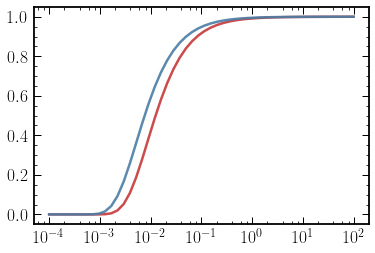

In [7]:
def J_bb(z):
    
    z_mu = 1.98e6
    
    return 0.983 * np.exp(-(z/z_mu)**2.5) * (1 - 0.0381 * (z/z_mu)**2.29)

# Surviving Probability
# From Chluba 2015 1506.06582
def survival_prob(x, z):
    
    xc_DC = 8.60e-3 * ((1.+z)/2e6)**0.5
    xc_BR = 1.23e-3 * ((1.+z)/2e6)**(-0.672)
    
    xc = np.sqrt(xc_DC**2 + xc_BR**2)
    
    return np.exp(-xc/x)


def lambda_func(x_prime, z_prime):
    
    return alpha_rho * (x_prime - (x_prime - x_0 * survival_prob(x_prime, z_prime)) * J_bb(z_prime))


# Temperature Shift
def T_shift(x):
    
    T_shift = np.where(x<=300, x*np.exp(x)/(np.exp(x) - 1), x)
    
    return T_shift


# [[[ Note! For definition of I0, G, M, we should include T0 for doing the variation ]]]

# Black Body Intensity
def I0(x, T0, units='eV_per_cmSq'):
    
    if   units == 'eV_per_cmSq': # units:    eV * cm^-2 * sr^-1
        prefac = 1
    elif units == 'SI':          # SI units: kg * s^-2 * sr^-1
        prefac = eV_to_J * (1/cm_to_m)**2
    elif units == 'MJy':         # units:    MJy * sr^-1
        prefac = eV_to_J * (1/cm_to_m)**2 * 1e26 / 1e6
        
    I0 = np.where(x<=300, prefac * 2 * T0**3 / h**2 / c**2  * x**3 / (np.exp(x)-1), 0 )
        
    return I0


# rho_bar(x):
# Normalized and Dimless Intensity, Defined in Hook2023
def rho_bar(x):
    
    return (15/np.pi**4) * x**3/(np.exp(x)-1)


# G-function (Chluba 15)
def G(x, T0, units='eV_per_cmSq'):

    return I0(x, T0, units=units) * T_shift(x)


# M-function (Chluba 15)
def M(x, T0, units='eV_per_cmSq'):
    
    return G(x, T0, units=units) * (alpha_mu - 1./x)

# --------------------------------------------
# Plot Survival Probability (mu-era)

xi_ary = np.logspace(-4, 2)

plt.xscale('log')

plt.plot(xi_ary, survival_prob(xi_ary, 2e6))
plt.plot(xi_ary, survival_prob(xi_ary, 4e5))

ax = plt.gca()

locmaj = ticker.LogLocator(base=10,numticks=12)
ax.xaxis.set_major_locator(locmaj)

locmin = ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(ticker.NullFormatter())

## 1E. Functions (Special, for y-era)

Compton y-parameter for photon distribution

\begin{equation}
y_\gamma = \int \frac{T_\gamma}{m_e} \frac{\sigma_T n_e}{H(z)(1+z)} dz.
\end{equation}


Compton y-parameter for electron distribution

\begin{equation}
y_e = \int \frac{T_e}{m_e} \frac{\sigma_T n_e}{H(z)(1+z)} dz.
\end{equation}

In the definition of $y_\gamma$ and $y_e$, we fix $T_0=2.7255\text{K}$. 


BR emissivity

\begin{equation}
\Lambda_\text{BR} = \frac{\alpha \lambda_e^3}{2 \pi \sqrt{6 \pi}} n_{\text{free} p} \theta_e^{-7/2} g_\text{ff}(x_e),
\end{equation}

where $\theta_e = T_e/m_e$, $x_e = \omega/T_e$, $n_{\text{free} p} = X_{e,\text{H}} n_\text{H}$. 

Photon survival probability

\begin{equation}
P_s(x,z) \simeq e^{-\tau_\text{ff}(x,z)},
\end{equation}
where 

\begin{equation}
\tau_\text{ff}(x,z) = \int^z_0 \frac{\Lambda_\text{BR}(z,x_e) ( 1 - e^{-x_e} )}{x_e^3} \frac{\sigma_T n_e c dz}{H(1+z)}
\end{equation}

In [8]:
# Y-function (Chluba 15)
def Y(x, T0, units='eV_per_cmSq'):
    
    Y = G(x, T0, units=units) * ( x/np.tanh(x/2)-4 )
    
    return Y

def f(x):
    
    return np.exp(-x) * ( 1 + x**2/2 )

# Compton-y parameter (Photon)
# Modified by Xucheng by replacing ``x_e(z_to_int) * ne0 * (1.0 + z_to_int) ** 3'' with ``n_e(z)''
def y_gamma(z):
    
    z_to_int = np.logspace(-5, np.log10(z), 500)
    
    fac_1 = TCMB_0 * (1.0 + z_to_int) / m_e

    fac_2 = thomson_xsec * n_e(z_to_int) * c / ( hubble(z_to_int) / hbar * (1.0 + z_to_int))

    return np.trapz(fac_1 * fac_2, z_to_int)


# T_e: Electron Temperature
# in eV   
def T_e(z):
    
    try:
        
        _ = iter(z)
        
        T_out = np.zeros_like(z)

        T_out[z  < 2999] = np.interp(z[z < 2999], np.flipud(x_e_data[0]) - 1.0, np.flipud(x_e_data[1]))
        T_out[z >= 2999] = (1.0 + z[z >= 2999]) * TCMB_0
    
    except:
        
        if z < 2999:
            
            T_out = np.interp(z, np.flipud(x_e_data[0]) - 1.0, np.flipud(x_e_data[1]))

        else:
            
            T_out = (1.0 + z) * TCMB_0

    return T_out


# Approx gff for high x (Draine)
def approx_high_x_Draine(x, T_e):
    
    theta_e = T_e / m_e
        
    return np.log(np.exp(1.0) + np.exp(5.960 - np.sqrt(3) / np.pi * np.log(270.783 * x * theta_e ** (-0.5))))


# Approx gff for low x (Draine)
def approx_low_x_Draine(x, T_e):
    
    theta_e = T_e / m_e
    
    return 4.691 * (1.0 - 0.118 * np.log(27.0783 * x * theta_e ** (-0.5)))


# Gaunt factor: g_ff    (Modifed by Xucheng)
# x    : 1D array N_x
# g_ff : 1D array N_x
def g_ff(x, T_e):  # here we define the Gaunt factor as in https://astrojacobli.github.io/astro-ph/ISM/Draine.pdf, sec.10.2
    
    # thr = 1e-3
    
    g_ff_out = approx_high_x_Draine(x, T_e)

    return g_ff_out


# Lambda_BR           (Modifed by Xucheng, Double-checked with Andrea's Code)
# x    : 1D array N_x
# XeH  : 1D array N_XeH

# [[[Warning: Xe is the ionization ratio, not the dimless frequency]]]
def Lambda_BR(x, XeH, z):
    
    theta_e = T_e(z) / m_e
    
    # Number density of free proton
    # 1D array N_XeH
    # n_p = ne0 * (1.0 + z) ** 3 * XeH  # in cm^-3
    n_free_p = n_H(z) * XeH  # in cm^-3

    # 2D array N_x * 1
    x_electron = x[:,None] * TCMB_0 * (1.0 + z) / T_e(z)

    # 2D array N_x * N_Xe
    Lambda_BR = alpha * lambda_e ** 3 / (2 * np.pi * np.sqrt(6 * np.pi)) * n_free_p * theta_e ** (-7.0 / 2.0) * g_ff(x_electron, T_e(z))
    
    return Lambda_BR


# tau_ff
# x    : 1D array N_x
# z    : Number
def tau_ff(x, z):
    
    N_z_to_int = 500
    
    # 1D array N_z_to_int:  small number to z
    z_to_int = np.logspace(-5, np.log10(z), N_z_to_int)
    
    # 2D array N_x * N_z_to_int
    # [:, None] make x to transfer from 1D array to N_x * 1 2D array
    x_electron = x[:,None] * TCMB_0 * (1.0 + z_to_int) / T_e(z_to_int)

    # 2D array N_x * N_z_to_int
    # <<< XG replace 'x_e' with 'XeH_interp' >>>
    Lambda = Lambda_BR(x, XeH_interp(z_to_int), z_to_int)

    # 2D array N_x * N_z_to_int
    fac_1 = Lambda * (1 - np.exp(-x_electron)) / x_electron ** 3

    # 1D array N_z_to_int
    # <<< XG replace 'x_e' with 'XeH_interp' >>>
    # <<< XG replace 'ne0 * (1.0 + z_to_int) ** 3' with 'n_e(z)' >>>
    fac_2 = thomson_xsec * n_e(z_to_int) * c / (hubble(z_to_int) / hbar * (1.0 + z_to_int))
    
    # 1D array N_x
    # ( Note that fac_1 * fac_2 is a 2D array N_x * N_z_to_int )
    tau_ff = np.trapz(fac_1 * fac_2, z_to_int)
    
    return tau_ff

# 2. Formalism of $\gamma \rightarrow A'$ Transition

# 3. Calc and interp: $z_\text{res}(m_{A'},x)$ and $P_{\gamma \rightarrow A'}(m_{A'},x)$

# 4. Green's Function: Pure $\mu$ and Pure $y$

## 4A. Green's Function ($\mu$-era)

Green's function for $\mu$-era

\begin{equation}
G^\text{Chluba}_\text{$\mu$-era}(x,x',z';\color{magenta}{T_0}) = G^\text{Chluba}_{\mu}(x,x',z';\color{magenta}{T_0}) + G^\text{Chluba}_{\mathcal{T}}(x,x',z';\color{magenta}{T_0}). 
\end{equation}

M-Term ($3/\kappa_c \simeq 1.4$)

\begin{equation}
G^\text{Chluba}_{\mu}(x,x',z';\color{magenta}{T_0}) = \frac{3 \alpha_\rho x'}{\kappa^c} \left( 1 - P_s(x',z') \frac{x_0}{x'} \right) \cdot J^*(z') \cdot M^\text{Chluba}(x;\color{magenta}{T_0})
\end{equation}

T-Term

\begin{equation}
G^\text{Chluba}_{ \mathcal{T} }(x,x',z';\color{magenta}{T_0}) = \frac{1}{4} \lambda(x',z') \cdot G^\text{Chluba}(x;\color{magenta}{T_0}),
\end{equation}

where 

\begin{equation}
\lambda(x',z') = \alpha_\rho x' \left[ 1 - \left( 1 - P_s(x',z') \frac{x_0}{x'} \right) J^*(z') \right]. 
\end{equation}

In [9]:
# Green's Function in mu-era: M-part
def greens_mu_M(x, x_prime, z_prime,  T0, units='eV_per_cmSq'):
    
    # 2D array  N_x * N_xp
    # Note that:
    # f(x)            : 1D array N_x
    # f(x)[:,None]    : 2D array N_x * N_xp
    greens_mu_ary = (   3 * alpha_rho / kappa_c
        * (x_prime - x_0 * survival_prob(x_prime, z_prime))
        * J_bb(z_prime) * M(x, T0, units = units)[:, None]   )
    
    return greens_mu_ary

# Green's Function in mu-era: T-part
def greens_mu_T(x, x_prime, z_prime,  T0, units='eV_per_cmSq'):
    
    # 2D array  N_x * N_xp
    # Note that:
    # f(x)            : 1D array N_x
    # f(x)[:,None]    : 2D array N_x * N_xp
    greens_mu_ary = ( lambda_func(x_prime, z_prime) * G(x, T0, units = units)[:, None] / 4. )
    
    return greens_mu_ary

# Green's Function in mu-era: M+T
def greens_mu_MT(x, x_prime, z_prime,  T0, units='eV_per_cmSq'):
    
    # 2D array  N_x * N_xp
    
    greens_mu_M_ary =  greens_mu_M(x, x_prime, z_prime, T0, units=units)
    
    greens_mu_T_ary =  greens_mu_T(x, x_prime, z_prime, T0, units=units)
    
    greens_mu_ary   =  greens_mu_M_ary + greens_mu_T_ary
    
    return greens_mu_ary

## 4B. Green's Function (y era)

### $G_y$: Green's function for y-era

\begin{equation}
\begin{aligned}
G_y^\text{Chluba}(x,x',z';\color{magenta}{T_0}) = G_Y^\text{Chluba}(x,x',z';\color{magenta}{T_0}) + G_\text{Doppler}^\text{Chluba}(x,x',z';\color{magenta}{T_0}),
\end{aligned}
\end{equation}

where

\begin{equation}
\boxed{ G_Y^\text{Chluba}(x,x',z';\color{magenta}{T_0}) = \alpha_\rho x' \left(1 - \frac{e^{ 4 (\alpha+\beta) y_\gamma(z') } e^{-\tau_\text{ff}(x',z')} }{1+x' y_\gamma(z')}\right) \frac{Y^\text{Chluba}(x, \color{magenta}{T_0})}{4} }
\end{equation}

and

\begin{equation}
\boxed{ G_\text{Doppler}^\text{Chluba}(x,x',z';\color{magenta}{T_0}) = \alpha_\rho x' \frac{\rho_\gamma(\color{magenta}{T_0})}{4\pi} \frac{2\pi}{\color{magenta}{T_0}} \frac{ e^{-\frac{1}{4 \beta y_\gamma(z')} \left\{\ln\left[x \left(1/x' + y_\gamma(z') \right)\right] - \alpha y_\gamma(z') \right\}^2 }  }{ x' \sqrt{4 \pi \beta y_\gamma(z')}} e^{-\tau_\text{ff}(x',z')} }.
\end{equation}

Here, 

\begin{equation}
\rho_\gamma(T_0) = \frac{\pi^2}{15} T_0^4
\end{equation}

and

\begin{equation}
\alpha(x',z') = \frac{3 - 2 f(x')}{ \sqrt{1+x'y_\gamma(z')} }, \quad \quad \beta(x',z') = \frac{1}{1+x' y_\gamma(z') \left[ 1 - f(x') \right] }. 
\end{equation}

### $G_y$ in $y_\gamma \ll 1$ Limit

When $y_\gamma \ll 1$, we approximately have

\begin{equation}
\frac{ e^{-\frac{1}{4 \beta y_\gamma(z')} \left\{\ln\left[x \left(1/x' + y_\gamma(z') \right)\right] - \alpha y_\gamma(z') \right\}^2 }  }{ x' \sqrt{4 \pi \beta y_\gamma(z')}}  \simeq \frac{1}{x'} \delta \left(\ln\left(\frac{x}{x'}\right) \right) \simeq \delta(x-x').
\end{equation}

Using such an approximation, we can write the y-era Green's function as

\begin{equation}
\begin{aligned}
G_y^\text{Chluba}(x,x',z';\color{magenta}{T_0}) = G_Y^\text{Chluba}(x,x',z';\color{magenta}{T_0}) + G_\text{Doppler}^\text{Chluba}(x,x',z';\color{magenta}{T_0}),
\end{aligned}
\end{equation}

where 

\begin{equation}
\boxed{ G_Y^\text{Chluba}(x,x',z';\color{magenta}{T_0}) \simeq \alpha_\rho x' \left(1 - e^{-\tau_\text{ff}(x',z')}\right) \frac{Y^\text{Chluba}(x, \color{magenta}{T_0})}{4} },
\end{equation}

and 

\begin{equation}
\boxed{ G_\text{Doppler}^\text{Chluba}(x,x',z';\color{magenta}{T_0}) \simeq \alpha_\rho x' \frac{\rho_\gamma( \color{magenta}{T_0} )}{4\pi} \frac{2\pi}{ \color{magenta}{T_0} } \delta(x-x') e^{-\tau_\text{ff}(x',z')} }.
\end{equation}

In [10]:
# alpha function defined in Hook2023 and Chluba2015
def alpha_func(x_prime,z_prime):
    
    # Compton y-parameter (photon)
    y = y_gamma(z_prime)
    
    # alpha
    alpha_func = ( 3 - 2 * f(x_prime) )/np.sqrt(1+x_prime * y)
    
    return alpha_func


# beta function defined in Hook2023 and Chluba2015
def beta_func(x_prime,z_prime):
    
    # Compton y-parameter (photon)
    y = y_gamma(z_prime)
    
    # beta
    beta_func = 1/( 1 + x_prime * y * (1-f(x_prime)) )
    
    return beta_func


# Green's function: y-era (Y-part)
# x   : 1D array N_x
# xp  : 1D array N_xp
# T0  : Number  # in eV
def greens_Y(x,x_prime,z_prime,T0,units="eV_per_cmSq"):
    
    if   units == 'eV_per_cmSq': # units:    eV * cm^-2 * sr^-1
        prefac = 1
    elif units == 'SI':          # SI units: kg * s^-2 * sr^-1
        prefac = eV_to_J * (1/cm_to_m)**2
    elif units == 'MJy':         # units:    MJy * sr^-1
        prefac = eV_to_J * (1/cm_to_m)**2 * 1e26 / 1e6    
    
    # Compton y-parameter (photon)
    y = y_gamma(z_prime)
    
    # <<<Use T0_vary>>> in 'rho_gamma(T0)'
    # photon energy density
    rho_gamma = (np.pi**2/15) * T0**4 /( hbar*c )**3  # in eV/cm^3
    
    # tau_ff
    # 1D array N_xp
    tau = tau_ff(x_prime, z_prime)
    
    # alpha
    alpha = (3-2 * f(x_prime))/np.sqrt(1+x_prime * y)
    
    # beta
    beta = 1/( 1 + x_prime * y * (1-f(x_prime)) )
    
    
    # <<<Use T0_vary>>> in 'Y(x_prime, T0, units=units)'
    # 2D array: N_x * N_xp
    # We use [:,None] to make Y(x) to be a 2D N_x * 1 array
    # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    term_Y = (1.0 - np.exp(y * (alpha + beta)) * np.exp(-tau) / (1.0 + x_prime * y)) * Y(x, T0, units="eV_per_cmSq")[:, None] / 4
    # in eV/cm^2
    # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    
    # Correct (Modified Chluba)
    # 2D array: N_x * N_xp
    green_Y = prefac * term_Y * x_prime * alpha_rho  
    
    return green_Y


# Green's function: y-era (Doppler-part)
# x   : 1D array N_x
# xp  : 1D array N_xp
# T0  : Number  # in eV
def greens_Doppler(x,x_prime,z_prime,T0,units="eV_per_cmSq"):
    
    if   units == 'eV_per_cmSq': # units:    eV * cm^-2 * sr^-1
        prefac = 1
    elif units == 'SI':          # SI units: kg * s^-2 * sr^-1
        prefac = eV_to_J * (1/cm_to_m)**2
    elif units == 'MJy':         # units:    MJy * sr^-1
        prefac = eV_to_J * (1/cm_to_m)**2 * 1e26 / 1e6    
        
    # Compton y-parameter (photon)
    y = y_gamma(z_prime)
    
    # <<<Use T0_vary>>> in 'rho_gamma(T0)'
    # photon energy density
    rho_gamma = (np.pi**2/15) * T0**4 /( hbar*c )**3  # in eV/cm^3
    
    # tau_ff
    # 1D array N_xp
    tau = tau_ff(x_prime, z_prime)
    
    # alpha
    alpha = (3-2 * f(x_prime))/np.sqrt(1+x_prime * y)
    
    # beta
    beta = 1/( 1 + x_prime * y * (1-f(x_prime)) )    
 
    # 2D array: N_x * N_xp
    # We use [:,None] to make x to be a 2D N_x * 1 array
    gaussian = np.exp(-((np.log(x[:, None] / x_prime) - alpha * y + np.log(1 + x_prime * y)) ** 2) / (4 * y * beta)) / (x_prime * np.sqrt(4 * np.pi * y * beta))
    
    # <<<Use T0_vary>>> in '2pi/T0'
    # 2D array: N_x * N_xp
    term_Doppler = c * hbar * ( rho_gamma / (4*np.pi) )  * ( 2*np.pi/T0 ) * np.exp(-tau) * gaussian
    # in eV/cm^2

    # Correct (Modified Chluba)
    # 2D array: N_x * N_xp
    green_Doppler = prefac * term_Doppler * x_prime * alpha_rho
    
    return green_Doppler


# Green's function: y-era (Total)
# x   : 1D array N_x
# xp  : 1D array N_xp
# T0  : Number  # in eV
def greens_y(x,x_prime,z_prime,T0,units="eV_per_cmSq"):
    
    if   units == 'eV_per_cmSq': # units:    eV * cm^-2 * sr^-1
        prefac = 1
    elif units == 'SI':          # SI units: kg * s^-2 * sr^-1
        prefac = eV_to_J * (1/cm_to_m)**2
    elif units == 'MJy':         # units:    MJy * sr^-1
        prefac = eV_to_J * (1/cm_to_m)**2 * 1e26 / 1e6

    # Compton y-parameter (photon)
    y = y_gamma(z_prime)
    
    # <<<Use T0_vary>>> in 'rho_gamma(T0)'
    # photon energy density
    rho_gamma = (np.pi**2/15) * T0**4 /( hbar*c )**3  # in eV/cm^3
    
    # tau_ff
    # 1D array N_xp
    tau = tau_ff(x_prime, z_prime)
    
    # alpha
    alpha = (3-2 * f(x_prime))/np.sqrt(1+x_prime * y)
    
    # beta
    beta = 1/( 1 + x_prime * y * (1-f(x_prime)) )
    
    # 2D array: N_x * N_xp
    # We use [:,None] to make x to be a 2D N_x * 1 array
    gaussian = np.exp(-((np.log(x[:, None] / x_prime) - alpha * y + np.log(1 + x_prime * y)) ** 2) / (4 * y * beta)) / (x_prime * np.sqrt(4 * np.pi * y * beta))

    # <<<Use T0_vary>>> in 'Y(x_prime, T0, units=units)'
    # 2D array: N_x * N_xp
    # We use [:,None] to make Y(x) to be a 2D N_x * 1 array
    term_Y = (1.0 - np.exp(y * (alpha + beta)) * np.exp(-tau) / (1.0 + x_prime * y)) * Y(x, T0, units="eV_per_cmSq")[:, None] / 4
    # in eV/cm^2
    
    # <<<Use T0_vary>>> in '2pi/T0'
    # 2D array: N_x * N_xp
    term_Doppler = c * hbar * ( rho_gamma / (4*np.pi) )  * ( 2*np.pi/T0 ) * np.exp(-tau) * gaussian
    # in eV/cm^2
    
    # Correct (Modified Chluba)
    # 2D array: N_x * N_xp
    # green_y = prefac * (term_Y) * x_prime * alpha_rho
    # green_y = prefac * (term_Doppler) * x_prime * alpha_rho
    green_y = prefac * (term_Y + term_Doppler) * x_prime * alpha_rho
    
    return green_y


# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# Test of the Code
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

x_test          = np.array([10])
x_prime_test    = np.array([0.1,1,10])
z_prime_test    = 10**5
# z_prime_test    = zres_interp(10**(-5),0)[0]
T0_test         = TCMB_0

ratio_test = (greens_Y(x_test,x_prime_test,z_prime_test,T0_test,units="eV_per_cmSq") + greens_Doppler(x_test,x_prime_test,z_prime_test,T0_test,units="eV_per_cmSq") )/greens_y(x_test,x_prime_test,z_prime_test,T0_test,units="eV_per_cmSq")

print('x                     = ', x_test[0])
print('x_prime               = ', x_prime_test[0])
print('z_prime               = ', z_prime_test)
print('T0                    = ', T0_test/K, 'K')
print('(G_Y+G_Doppler)/G_y   = ', ratio_test[0,0])

x                     =  10
x_prime               =  0.1
z_prime               =  100000
T0                    =  2.7255 K
(G_Y+G_Doppler)/G_y   =  1.0


In [11]:
x_prime_test = 15
z_prime_test = 6e4

y_gamma_test = y_gamma(z_prime_test)

alpha_test   = alpha_func(x_prime_test,z_prime_test)
beta_test    = beta_func(x_prime_test,z_prime_test)

survival_prob_mu_test = survival_prob(x_prime_test,z_prime_test)
survival_prob_y_test  = np.exp( - tau_ff(np.array([x_prime_test]), z_prime_test) )[0]

print( 'x_prime            = ', x_prime_test)
print( 'z_prime            = ', z_prime_test)
print( '')
print( 'y_gamma            = ', y_gamma_test)
print( '')
print( 'x_prime * y_gamma  = ', x_prime_test*y_gamma_test )
print( '')
print( 'survival prob (mu) = ', survival_prob_mu_test)
print( 'survival prob (y)  = ', survival_prob_y_test)
print( 'alpha              = ', alpha_test )
print( 'beta               = ', beta_test )
print( '')
print( '')
print( survival_prob_y_test * np.exp( (alpha_test + beta_test) * y_gamma_test )/(1+x_prime_test*y_gamma_test) )

x_prime            =  15
z_prime            =  60000.0

y_gamma            =  0.1652655417601046

x_prime * y_gamma  =  2.478983126401569

survival prob (mu) =  0.9991293662924291
survival prob (y)  =  0.9999999917042052
alpha              =  1.6083665821953461
beta               =  0.28744742480456903


0.39320376110472954


# 5. Green's Function: $\mu-y$ Transition Era

### Chluba15 Transition Function

\begin{equation}
\mathscr{T}_\mu(z) = 1 - \exp\left[ - \left(\frac{1+z}{5.8 \times 10^4}\right)^{1.88} \right]  \quad \text{and} \quad \mathscr{T}_y(z) = \frac{1}{1+\left(\frac{1+z}{6 \times 10^4}\right)^{2.58}}.
\end{equation}

The spectral distortion in $\mu-y$ transition era is
\begin{equation}
\Delta I(x; m_{A'}, \epsilon;  \color{magenta}{T_0}) = - \frac{1}{2 \zeta(3)} \int dx' G^{(Chluba)}(x,x',z_\text{res}; \color{magenta}{T_0}) \frac{x'^2}{e^{x'}-1} P_{\gamma \rightarrow A'}(x',z_\text{res}),
\end{equation}

where 

\begin{equation}
G^{(Chluba)}(x,x',z_\text{res};\color{magenta}{T_0}) = \mathscr{T}_\mu(z_\text{res}) \times G^{(Chluba)}_\mu(x,x',z_\text{res};\color{magenta}{T_0}) + \mathscr{T}_y(z_\text{res}) \times G^{(Chluba)}_y(x,x',z_\text{res};\color{magenta}{T_0}).
\end{equation}

Here, we have
\begin{equation}
G^{(Chluba)}_y(x,x',z_\text{res};\color{magenta}{T_0}) = G^{(Chluba)}_Y(x,x',z_\text{res};\color{magenta}{T_0}) + G^{(Chluba)}_\text{Doppler}(x,x',z_\text{res};\color{magenta}{T_0})
\end{equation}

## Other reasonable transition functions

These transition functions are found by Xucheng after comparing on the shape of Green's function with Chluba15.

### Exponential Transition Function (General)

\begin{equation}
\mathscr{T}_\mu(z) = 1 - \exp\left[ - \left(\frac{1+z}{1+z_\mathrm{trans}}\right)^{\mathrm{Power}} \right].
\end{equation}

### Transition Function (Chluba 2015):

\begin{equation}
z_\mathrm{trans} = 5.8 \times 10^4, \quad \mathrm{Power} = 1.88
\end{equation}

### Transition Function (Xucheng):

\begin{equation}
z_\mathrm{trans} = (5.8 \times 10^4, 10^5, 1.4 \times 10^5, 1.7 \times 10^5), \quad \mathrm{Power} = (1.88, 3, 5)
\end{equation}

### Best Value (Xucheng)

\begin{equation}
z_\mathrm{trans} = 1.7 \times 10^5, \quad \mathrm{Power} = (3,5)
\end{equation}

z_trans =  309000.0
r_trans =  3.28


<Figure size 432x288 with 0 Axes>

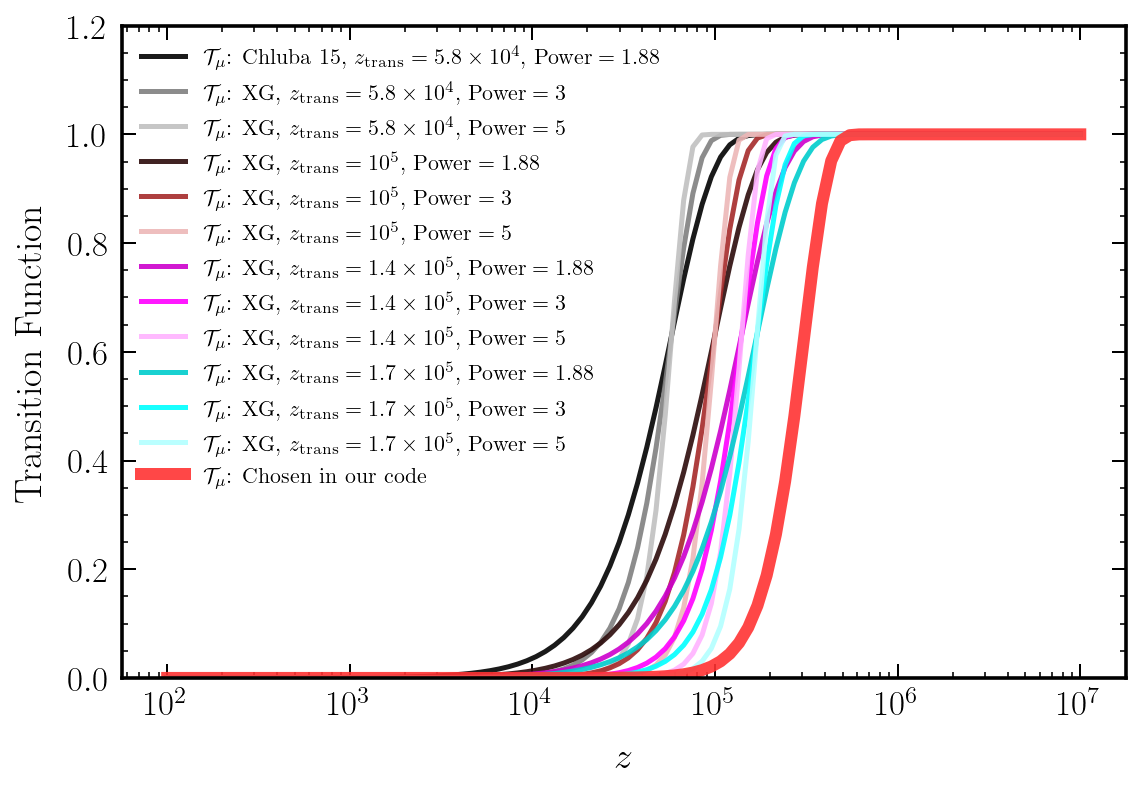

In [12]:
# Transition Function:
def Ttrans_mu_para(z,z_trans,Power_trans):
    
    Ttrans_mu = 1 - np.exp( -((1+z)/(1+z_trans))**Power_trans )
    
    return Ttrans_mu

z_trans_A     = 5.8 * 10**4
z_trans_B     = 10**5 
z_trans_C     = 1.4 * 10**5
z_trans_D     = 1.7 * 10**5
z_trans_E     = 1.9 * 10**5

Power_trans_A = 1.88
Power_trans_B = 3
Power_trans_C = 5

color_5p8e4_1p88 = lighten_color('gray', 2)
color_5p8e4_3    = lighten_color('gray', 1)
color_5p8e4_5    = lighten_color('gray', 0.5)

color_10e4_1p88  = lighten_color('brown', 1.5)
color_10e4_3     = lighten_color('brown', 1)
color_10e4_5     = lighten_color('brown', 0.3)

color_14e4_1p88  = lighten_color('magenta', 1.2)
color_14e4_3     = lighten_color('magenta', 1)
color_14e4_5     = lighten_color('magenta', 0.3)

color_17e4_1p88  = lighten_color('cyan', 1.2)
color_17e4_3     = lighten_color('cyan', 1)
color_17e4_5     = lighten_color('cyan', 0.3)

# z_trans_choose = 1.3*10**5
# r_trans_choose = 4

z_trans_choose = 3.09e5
r_trans_choose = 3.28

# z_trans_choose = 3.08e5
# r_trans_choose = 3.40

# z_trans_choose = 1.23*10**5
# r_trans_choose = 10

print("z_trans = ", z_trans_choose)
print("r_trans = ", r_trans_choose)

def Ttrans_mu_Chluba15(z):
    
    z_trans     = z_trans_A
    Power_trans = Power_trans_A
    
    return Ttrans_mu_para(z,z_trans,Power_trans)

def Ttrans_mu(z):
    
    # Trans_mu = Ttrans_mu_para(z,1.3*10**5,6)
    Trans_mu = Ttrans_mu_para(z,z_trans_choose,r_trans_choose)
    
    return Trans_mu


# ========================================================
z_test = np.logspace(2,7,100)

Reg_test=10**(-5)

plt.figure()

set_matplotlib_formats('retina')
plt.figure(figsize=(9,6))

plt.xscale('log')
# plt.yscale('log')

plt.plot(z_test,  Ttrans_mu_Chluba15(z_test)                       , label = r'$\mathcal{T}_\mu$: Chluba 15, $z_\mathrm{trans} = 5.8 \times 10^4$, $\mathrm{Power} = 1.88$', color = color_5p8e4_1p88  )
plt.plot(z_test,  Ttrans_mu_para(z_test,z_trans_A,Power_trans_B)   , label = r'$\mathcal{T}_\mu$: XG, $z_\mathrm{trans} = 5.8 \times 10^4$, $\mathrm{Power} = 3$',           color = color_5p8e4_3 )
plt.plot(z_test,  Ttrans_mu_para(z_test,z_trans_A,Power_trans_C)   , label = r'$\mathcal{T}_\mu$: XG, $z_\mathrm{trans} = 5.8 \times 10^4$, $\mathrm{Power} = 5$',           color = color_5p8e4_5 )

plt.plot(z_test,  Ttrans_mu_para(z_test,z_trans_B,Power_trans_A)   , label = r'$\mathcal{T}_\mu$: XG, $z_\mathrm{trans} = 10^5$, $\mathrm{Power} = 1.88$',                   color = color_10e4_1p88  )
plt.plot(z_test,  Ttrans_mu_para(z_test,z_trans_B,Power_trans_B)   , label = r'$\mathcal{T}_\mu$: XG, $z_\mathrm{trans} = 10^5$, $\mathrm{Power} = 3$',                      color = color_10e4_3     )
plt.plot(z_test,  Ttrans_mu_para(z_test,z_trans_B,Power_trans_C)   , label = r'$\mathcal{T}_\mu$: XG, $z_\mathrm{trans} = 10^5$, $\mathrm{Power} = 5$',                      color = color_10e4_5     )

plt.plot(z_test,  Ttrans_mu_para(z_test,z_trans_C,Power_trans_A)   , label = r'$\mathcal{T}_\mu$: XG, $z_\mathrm{trans} = 1.4 \times 10^5$, $\mathrm{Power} = 1.88$',        color = color_14e4_1p88  )
plt.plot(z_test,  Ttrans_mu_para(z_test,z_trans_C,Power_trans_B)   , label = r'$\mathcal{T}_\mu$: XG, $z_\mathrm{trans} = 1.4 \times 10^5$, $\mathrm{Power} = 3$',           color = color_14e4_3     )
plt.plot(z_test,  Ttrans_mu_para(z_test,z_trans_C,Power_trans_C)   , label = r'$\mathcal{T}_\mu$: XG, $z_\mathrm{trans} = 1.4 \times 10^5$, $\mathrm{Power} = 5$',           color = color_14e4_5     )

plt.plot(z_test,  Ttrans_mu_para(z_test,z_trans_D,Power_trans_A)   , label = r'$\mathcal{T}_\mu$: XG, $z_\mathrm{trans} = 1.7 \times 10^5$, $\mathrm{Power} = 1.88$',        color = color_17e4_1p88  )
plt.plot(z_test,  Ttrans_mu_para(z_test,z_trans_D,Power_trans_B)   , label = r'$\mathcal{T}_\mu$: XG, $z_\mathrm{trans} = 1.7 \times 10^5$, $\mathrm{Power} = 3$',           color = color_17e4_3     )
plt.plot(z_test,  Ttrans_mu_para(z_test,z_trans_D,Power_trans_C)   , label = r'$\mathcal{T}_\mu$: XG, $z_\mathrm{trans} = 1.7 \times 10^5$, $\mathrm{Power} = 5$',           color = color_17e4_5     )

# plt.plot(z_test,  Ttrans_mu_XG_19e4_1p88(z_test) , label = r'$\mathcal{T}_\mu$: XG, $z_\mathrm{trans} = 1.9 \times 10^5$, $\mathrm{Power} = 1.88$', color = lighten_color('purple', 0.3))
# plt.plot(z_test,  Ttrans_mu_XG_19e4_3(z_test)    , label = r'$\mathcal{T}_\mu$: XG, $z_\mathrm{trans} = 1.9 \times 10^5$, $\mathrm{Power} = 3$', color = lighten_color('purple', 1) )
# plt.plot(z_test,  Ttrans_mu_XG_19e4_5(z_test)    , label = r'$\mathcal{T}_\mu$: XG, $z_\mathrm{trans} = 1.9 \times 10^5$, $\mathrm{Power} = 5$', color = lighten_color('purple', 1.2) )

plt.plot(z_test,  Ttrans_mu(z_test), label = r'$\mathcal{T}_\mu$: Chosen in our code', color = lighten_color('red', 0.8), linewidth=6)

# plt.title(r'$G_\mu(x,x^\prime,z^\prime)$ Normalization')

plt.xlabel(r'$z$')
plt.ylabel(r'Transition Function')

plt.ylim(0, 1.2)

plt.legend(fontsize=11)

plt.savefig('Trans_Func.pdf')

In [13]:
# Green's function: mu/y transition-era (Doppler-part)
# x   : 1D array N_x
# xp  : 1D array N_xp
# T0  : Number  # in eV
def greens_muy_trans(x,x_prime,z_prime,T0,units="eV_per_cmSq"):
    
    if  units == 'eV_per_cmSq':  # units:    eV * cm^-2 * sr^-1
        prefac = 1
    elif units == 'SI':          # SI units: kg * s^-2 * sr^-1
        prefac = eV_to_J * (1/cm_to_m)**2
    elif units == 'MJy':         # units:    MJy * sr^-1
        prefac = eV_to_J * (1/cm_to_m)**2 * 1e26 / 1e6
    
    T_mu = Ttrans_mu(z_prime)
    
    greens_muy_trans = T_mu * greens_mu_MT(x,x_prime,z_prime,T0,units=units) + (1-T_mu) * greens_y(x,x_prime,z_prime,T0,units=units)

    return greens_muy_trans

# 6.A. Transition Era Compare

In [14]:
# Import the shapes from Chluba 2015
# ---------------------------------------------------------------------------------
# nu[GHz]-G[MJy/sr]
# ---------------------------------------------------------------------------------
# x=0.001
nu_G_Chluba_xp1em3_z6e4     = np.transpose( np.array( pd.read_csv('xp1em3_z6e4.csv') ) )
nu_G_Chluba_xp1em3_z7e4     = np.transpose( np.array( pd.read_csv('xp1em3_z7e4.csv') ) )
nu_G_Chluba_xp1em3_z8e4     = np.transpose( np.array( pd.read_csv('xp1em3_z8e4.csv') ) )
nu_G_Chluba_xp1em3_z9e4     = np.transpose( np.array( pd.read_csv('xp1em3_z9e4.csv') ) )
nu_G_Chluba_xp1em3_z1e5     = np.transpose( np.array( pd.read_csv('xp1em3_z1e5.csv') ) )
nu_G_Chluba_xp1em3_z1p5e5   = np.transpose( np.array( pd.read_csv('xp1em3_z1p5e5.csv') ) )
nu_G_Chluba_xp1em3_z2e5     = np.transpose( np.array( pd.read_csv('xp1em3_z2e5.csv') ) )
nu_G_Chluba_xp1em3_z3e5     = np.transpose( np.array( pd.read_csv('xp1em3_z3e5.csv') ) )

# x=0.01
nu_G_Chluba_xp1em2_z6e4     = np.transpose( np.array( pd.read_csv('xp1em2_z6e4.csv') ) )
nu_G_Chluba_xp1em2_z7e4     = np.transpose( np.array( pd.read_csv('xp1em2_z7e4.csv') ) )
nu_G_Chluba_xp1em2_z8e4     = np.transpose( np.array( pd.read_csv('xp1em2_z8e4.csv') ) )
nu_G_Chluba_xp1em2_z9e4     = np.transpose( np.array( pd.read_csv('xp1em2_z9e4.csv') ) )
nu_G_Chluba_xp1em2_z1e5     = np.transpose( np.array( pd.read_csv('xp1em2_z1e5.csv') ) )
nu_G_Chluba_xp1em2_z1p5e5   = np.transpose( np.array( pd.read_csv('xp1em2_z1p5e5.csv') ) )
nu_G_Chluba_xp1em2_z2e5     = np.transpose( np.array( pd.read_csv('xp1em2_z2e5.csv') ) )
nu_G_Chluba_xp1em2_z3e5     = np.transpose( np.array( pd.read_csv('xp1em2_z3e5.csv') ) )

# x=0.1
nu_G_Chluba_xp1em1_z6e4   = np.transpose( np.array( pd.read_csv('xp1em1_z6e4.csv') ) )
nu_G_Chluba_xp1em1_z7e4   = np.transpose( np.array( pd.read_csv('xp1em1_z7e4.csv') ) )
nu_G_Chluba_xp1em1_z8e4   = np.transpose( np.array( pd.read_csv('xp1em1_z8e4.csv') ) )
nu_G_Chluba_xp1em1_z9e4   = np.transpose( np.array( pd.read_csv('xp1em1_z9e4.csv') ) )
nu_G_Chluba_xp1em1_z1e5   = np.transpose( np.array( pd.read_csv('xp1em1_z1e5.csv') ) )
nu_G_Chluba_xp1em1_z1p5e5 = np.transpose( np.array( pd.read_csv('xp1em1_z1p5e5.csv') ) )
nu_G_Chluba_xp1em1_z2e5   = np.transpose( np.array( pd.read_csv('xp1em1_z2e5.csv') ) )
nu_G_Chluba_xp1em1_z3e5   = np.transpose( np.array( pd.read_csv('xp1em1_z3e5.csv') ) )

# x=1
nu_G_Chluba_xp1_z6e4      = np.transpose( np.array( pd.read_csv('xp1_z6e4.csv') ) )
nu_G_Chluba_xp1_z7e4      = np.transpose( np.array( pd.read_csv('xp1_z7e4.csv') ) )
nu_G_Chluba_xp1_z8e4      = np.transpose( np.array( pd.read_csv('xp1_z8e4.csv') ) )
nu_G_Chluba_xp1_z9e4      = np.transpose( np.array( pd.read_csv('xp1_z9e4.csv') ) )
nu_G_Chluba_xp1_z1e5      = np.transpose( np.array( pd.read_csv('xp1_z1e5.csv') ) )
nu_G_Chluba_xp1_z1p5e5    = np.transpose( np.array( pd.read_csv('xp1_z1p5e5.csv') ) )
nu_G_Chluba_xp1_z2e5      = np.transpose( np.array( pd.read_csv('xp1_z2e5.csv') ) )
nu_G_Chluba_xp1_z3e5      = np.transpose( np.array( pd.read_csv('xp1_z3e5.csv') ) )

# x=5
nu_G_Chluba_xp5_z6e4      = np.transpose( np.array( pd.read_csv('xp5_z6e4.csv'  ) ) )
nu_G_Chluba_xp5_z7e4      = np.transpose( np.array( pd.read_csv('xp5_z7e4.csv'  ) ) )
nu_G_Chluba_xp5_z8e4      = np.transpose( np.array( pd.read_csv('xp5_z8e4.csv'  ) ) )
nu_G_Chluba_xp5_z9e4      = np.transpose( np.array( pd.read_csv('xp5_z9e4.csv'  ) ) )
nu_G_Chluba_xp5_z1e5      = np.transpose( np.array( pd.read_csv('xp5_z1e5.csv'  ) ) )
nu_G_Chluba_xp5_z1p5e5    = np.transpose( np.array( pd.read_csv('xp5_z1p5e5.csv') ) )
nu_G_Chluba_xp5_z2e5      = np.transpose( np.array( pd.read_csv('xp5_z2e5.csv'  ) ) )
nu_G_Chluba_xp5_z3e5      = np.transpose( np.array( pd.read_csv('xp5_z3e5.csv'  ) ) )

# x=15
nu_G_Chluba_xp15_z6e4     = np.transpose( np.array( pd.read_csv('xp15_z6e4.csv') ) )
nu_G_Chluba_xp15_z7e4     = np.transpose( np.array( pd.read_csv('xp15_z7e4.csv') ) )
nu_G_Chluba_xp15_z8e4     = np.transpose( np.array( pd.read_csv('xp15_z8e4.csv') ) )
nu_G_Chluba_xp15_z9e4     = np.transpose( np.array( pd.read_csv('xp15_z9e4.csv') ) )
nu_G_Chluba_xp15_z1e5     = np.transpose( np.array( pd.read_csv('xp15_z1e5.csv') ) )
nu_G_Chluba_xp15_z1p5e5   = np.transpose( np.array( pd.read_csv('xp15_z1p5e5.csv') ) )
nu_G_Chluba_xp15_z2e5     = np.transpose( np.array( pd.read_csv('xp15_z2e5.csv') ) )
nu_G_Chluba_xp15_z3e5     = np.transpose( np.array( pd.read_csv('xp15_z3e5.csv') ) )


# ---------------------------------------------------------------------------------
# x-G[MJy/sr]
# ---------------------------------------------------------------------------------
# x=0.001
x_G_Chluba_xp1em3_z6e4   = np.vstack((nu_G_Chluba_xp1em3_z6e4[0]*(1e9*sInv_to_eV)*(2*np.pi/TCMB_0), nu_G_Chluba_xp1em3_z6e4[1]))
x_G_Chluba_xp1em3_z7e4   = np.vstack((nu_G_Chluba_xp1em3_z7e4[0]*(1e9*sInv_to_eV)*(2*np.pi/TCMB_0), nu_G_Chluba_xp1em3_z7e4[1]))
x_G_Chluba_xp1em3_z8e4   = np.vstack((nu_G_Chluba_xp1em3_z8e4[0]*(1e9*sInv_to_eV)*(2*np.pi/TCMB_0), nu_G_Chluba_xp1em3_z8e4[1]))
x_G_Chluba_xp1em3_z9e4   = np.vstack((nu_G_Chluba_xp1em3_z9e4[0]*(1e9*sInv_to_eV)*(2*np.pi/TCMB_0), nu_G_Chluba_xp1em3_z9e4[1]))
x_G_Chluba_xp1em3_z1e5   = np.vstack((nu_G_Chluba_xp1em3_z1p5e5[0]*(1e9*sInv_to_eV)*(2*np.pi/TCMB_0), nu_G_Chluba_xp1em3_z1p5e5[1]))
x_G_Chluba_xp1em3_z1p5e5 = np.vstack((nu_G_Chluba_xp1em3_z1p5e5[0]*(1e9*sInv_to_eV)*(2*np.pi/TCMB_0), nu_G_Chluba_xp1em3_z1p5e5[1]))
x_G_Chluba_xp1em3_z2e5   = np.vstack((nu_G_Chluba_xp1em3_z2e5[0]*(1e9*sInv_to_eV)*(2*np.pi/TCMB_0), nu_G_Chluba_xp1em3_z2e5[1]))
x_G_Chluba_xp1em3_z3e5   = np.vstack((nu_G_Chluba_xp1em3_z3e5[0]*(1e9*sInv_to_eV)*(2*np.pi/TCMB_0), nu_G_Chluba_xp1em3_z3e5[1]))

# x=0.01
x_G_Chluba_xp1em2_z6e4    = np.vstack((nu_G_Chluba_xp1em2_z6e4[0]*(1e9*sInv_to_eV)*(2*np.pi/TCMB_0), nu_G_Chluba_xp1em2_z6e4[1]))
x_G_Chluba_xp1em2_z7e4    = np.vstack((nu_G_Chluba_xp1em2_z7e4[0]*(1e9*sInv_to_eV)*(2*np.pi/TCMB_0), nu_G_Chluba_xp1em2_z7e4[1]))
x_G_Chluba_xp1em2_z8e4    = np.vstack((nu_G_Chluba_xp1em2_z8e4[0]*(1e9*sInv_to_eV)*(2*np.pi/TCMB_0), nu_G_Chluba_xp1em2_z8e4[1]))
x_G_Chluba_xp1em2_z9e4    = np.vstack((nu_G_Chluba_xp1em2_z9e4[0]*(1e9*sInv_to_eV)*(2*np.pi/TCMB_0), nu_G_Chluba_xp1em2_z9e4[1]))
x_G_Chluba_xp1em2_z1e5    = np.vstack((nu_G_Chluba_xp1em2_z1e5[0]*(1e9*sInv_to_eV)*(2*np.pi/TCMB_0), nu_G_Chluba_xp1em2_z1e5[1]))
x_G_Chluba_xp1em2_z1p5e5  = np.vstack((nu_G_Chluba_xp1em2_z1p5e5[0]*(1e9*sInv_to_eV)*(2*np.pi/TCMB_0), nu_G_Chluba_xp1em2_z1p5e5[1]))
x_G_Chluba_xp1em2_z2e5    = np.vstack((nu_G_Chluba_xp1em2_z2e5[0]*(1e9*sInv_to_eV)*(2*np.pi/TCMB_0), nu_G_Chluba_xp1em2_z2e5[1]))
x_G_Chluba_xp1em2_z3e5    = np.vstack((nu_G_Chluba_xp1em2_z3e5[0]*(1e9*sInv_to_eV)*(2*np.pi/TCMB_0), nu_G_Chluba_xp1em2_z3e5[1]))

# x=0.1
x_G_Chluba_xp1em1_z6e4    = np.vstack((nu_G_Chluba_xp1em1_z6e4[0]*(1e9*sInv_to_eV)*(2*np.pi/TCMB_0), nu_G_Chluba_xp1em1_z6e4[1]))
x_G_Chluba_xp1em1_z7e4    = np.vstack((nu_G_Chluba_xp1em1_z7e4[0]*(1e9*sInv_to_eV)*(2*np.pi/TCMB_0), nu_G_Chluba_xp1em1_z7e4[1]))
x_G_Chluba_xp1em1_z8e4    = np.vstack((nu_G_Chluba_xp1em1_z8e4[0]*(1e9*sInv_to_eV)*(2*np.pi/TCMB_0), nu_G_Chluba_xp1em1_z8e4[1]))
x_G_Chluba_xp1em1_z9e4    = np.vstack((nu_G_Chluba_xp1em1_z9e4[0]*(1e9*sInv_to_eV)*(2*np.pi/TCMB_0), nu_G_Chluba_xp1em1_z9e4[1]))
x_G_Chluba_xp1em1_z1e5    = np.vstack((nu_G_Chluba_xp1em1_z1e5[0]*(1e9*sInv_to_eV)*(2*np.pi/TCMB_0), nu_G_Chluba_xp1em1_z1e5[1]))
x_G_Chluba_xp1em1_z1p5e5  = np.vstack((nu_G_Chluba_xp1em1_z1p5e5[0]*(1e9*sInv_to_eV)*(2*np.pi/TCMB_0), nu_G_Chluba_xp1em1_z1p5e5[1]))
x_G_Chluba_xp1em1_z2e5    = np.vstack((nu_G_Chluba_xp1em1_z2e5[0]*(1e9*sInv_to_eV)*(2*np.pi/TCMB_0), nu_G_Chluba_xp1em1_z2e5[1]))
x_G_Chluba_xp1em1_z3e5    = np.vstack((nu_G_Chluba_xp1em1_z3e5[0]*(1e9*sInv_to_eV)*(2*np.pi/TCMB_0), nu_G_Chluba_xp1em1_z3e5[1]))

# x=1
x_G_Chluba_xp1_z6e4       = np.vstack((nu_G_Chluba_xp1_z6e4[0]*(1e9*sInv_to_eV)*(2*np.pi/TCMB_0), nu_G_Chluba_xp1_z6e4[1]))
x_G_Chluba_xp1_z7e4       = np.vstack((nu_G_Chluba_xp1_z7e4[0]*(1e9*sInv_to_eV)*(2*np.pi/TCMB_0), nu_G_Chluba_xp1_z7e4[1]))
x_G_Chluba_xp1_z8e4       = np.vstack((nu_G_Chluba_xp1_z8e4[0]*(1e9*sInv_to_eV)*(2*np.pi/TCMB_0), nu_G_Chluba_xp1_z8e4[1]))
x_G_Chluba_xp1_z9e4       = np.vstack((nu_G_Chluba_xp1_z9e4[0]*(1e9*sInv_to_eV)*(2*np.pi/TCMB_0), nu_G_Chluba_xp1_z9e4[1]))
x_G_Chluba_xp1_z1e5       = np.vstack((nu_G_Chluba_xp1_z1e5[0]*(1e9*sInv_to_eV)*(2*np.pi/TCMB_0), nu_G_Chluba_xp1_z1e5[1]))
x_G_Chluba_xp1_z1p5e5     = np.vstack((nu_G_Chluba_xp1_z1p5e5[0]*(1e9*sInv_to_eV)*(2*np.pi/TCMB_0), nu_G_Chluba_xp1_z1p5e5[1]))
x_G_Chluba_xp1_z2e5       = np.vstack((nu_G_Chluba_xp1_z2e5[0]*(1e9*sInv_to_eV)*(2*np.pi/TCMB_0), nu_G_Chluba_xp1_z2e5[1]))
x_G_Chluba_xp1_z3e5       = np.vstack((nu_G_Chluba_xp1_z3e5[0]*(1e9*sInv_to_eV)*(2*np.pi/TCMB_0), nu_G_Chluba_xp1_z3e5[1]))

# x=5
x_G_Chluba_xp5_z6e4       = np.vstack((nu_G_Chluba_xp5_z6e4[0]*(1e9*sInv_to_eV)*(2*np.pi/TCMB_0), nu_G_Chluba_xp5_z6e4[1]))
x_G_Chluba_xp5_z7e4       = np.vstack((nu_G_Chluba_xp5_z7e4[0]*(1e9*sInv_to_eV)*(2*np.pi/TCMB_0), nu_G_Chluba_xp5_z7e4[1]))
x_G_Chluba_xp5_z8e4       = np.vstack((nu_G_Chluba_xp5_z8e4[0]*(1e9*sInv_to_eV)*(2*np.pi/TCMB_0), nu_G_Chluba_xp5_z8e4[1]))
x_G_Chluba_xp5_z9e4       = np.vstack((nu_G_Chluba_xp5_z9e4[0]*(1e9*sInv_to_eV)*(2*np.pi/TCMB_0), nu_G_Chluba_xp5_z9e4[1]))
x_G_Chluba_xp5_z1e5       = np.vstack((nu_G_Chluba_xp5_z1e5[0]*(1e9*sInv_to_eV)*(2*np.pi/TCMB_0), nu_G_Chluba_xp5_z1e5[1]))
x_G_Chluba_xp5_z1p5e5     = np.vstack((nu_G_Chluba_xp5_z1p5e5[0]*(1e9*sInv_to_eV)*(2*np.pi/TCMB_0), nu_G_Chluba_xp5_z1p5e5[1]))
x_G_Chluba_xp5_z2e5       = np.vstack((nu_G_Chluba_xp5_z2e5[0]*(1e9*sInv_to_eV)*(2*np.pi/TCMB_0), nu_G_Chluba_xp5_z2e5[1]))
x_G_Chluba_xp5_z3e5       = np.vstack((nu_G_Chluba_xp5_z3e5[0]*(1e9*sInv_to_eV)*(2*np.pi/TCMB_0), nu_G_Chluba_xp5_z3e5[1]))

# x=15
x_G_Chluba_xp15_z6e4      = np.vstack((nu_G_Chluba_xp15_z6e4[0]*(1e9*sInv_to_eV)*(2*np.pi/TCMB_0), nu_G_Chluba_xp15_z6e4[1]))
x_G_Chluba_xp15_z7e4      = np.vstack((nu_G_Chluba_xp15_z7e4[0]*(1e9*sInv_to_eV)*(2*np.pi/TCMB_0), nu_G_Chluba_xp15_z7e4[1]))
x_G_Chluba_xp15_z8e4      = np.vstack((nu_G_Chluba_xp15_z8e4[0]*(1e9*sInv_to_eV)*(2*np.pi/TCMB_0), nu_G_Chluba_xp15_z8e4[1]))
x_G_Chluba_xp15_z9e4      = np.vstack((nu_G_Chluba_xp15_z9e4[0]*(1e9*sInv_to_eV)*(2*np.pi/TCMB_0), nu_G_Chluba_xp15_z9e4[1]))
x_G_Chluba_xp15_z1e5      = np.vstack((nu_G_Chluba_xp15_z1e5[0]*(1e9*sInv_to_eV)*(2*np.pi/TCMB_0), nu_G_Chluba_xp15_z1e5[1]))
x_G_Chluba_xp15_z1p5e5    = np.vstack((nu_G_Chluba_xp15_z1p5e5[0]*(1e9*sInv_to_eV)*(2*np.pi/TCMB_0), nu_G_Chluba_xp15_z1p5e5[1]))
x_G_Chluba_xp15_z2e5      = np.vstack((nu_G_Chluba_xp15_z2e5[0]*(1e9*sInv_to_eV)*(2*np.pi/TCMB_0), nu_G_Chluba_xp15_z2e5[1]))
x_G_Chluba_xp15_z3e5      = np.vstack((nu_G_Chluba_xp15_z3e5[0]*(1e9*sInv_to_eV)*(2*np.pi/TCMB_0), nu_G_Chluba_xp15_z3e5[1]))

### Transition Era: $x=0.001$

x_prime    =  0.001
z_prime_1  =  300000
z_prime_2A =  200000
z_prime_3  =  60000
----------------------------
Transition Era:  10000 < z < 300000
----------------------------
z_trans =  309000.0
r_trans =  3.28


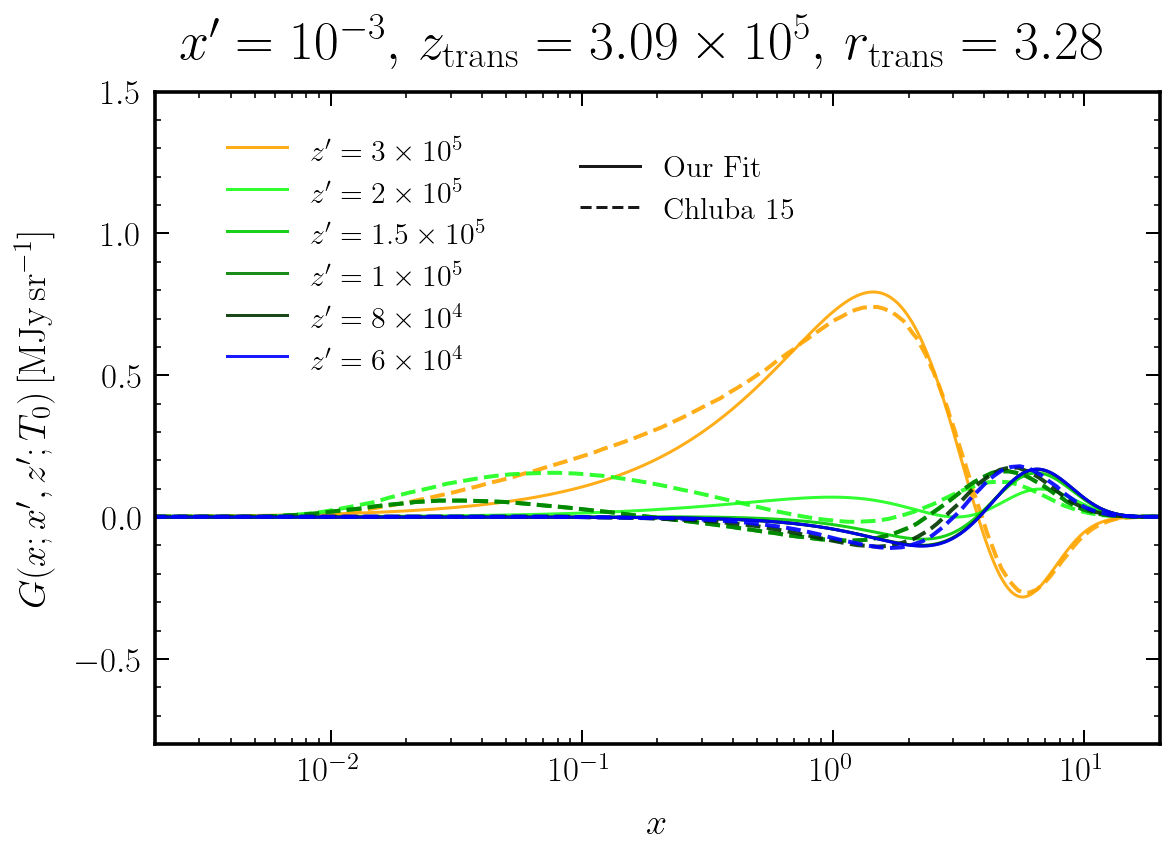

In [26]:
z_prime_test_1   = 3*10**5
z_prime_test_2A  = 2*10**5
z_prime_test_2B  = 1.5*10**5
z_prime_test_2C  = 1*10**5
z_prime_test_2D  = 8*10**4
z_prime_test_3   = 6*10**4

nu_ary_test = np.logspace(np.log10(1e-2),np.log10(2000),1000)  # GHz
x_ary_test  = nu_ary_test * (2*np.pi) * (10**9 * sInv_to_eV)/TCMB_0

x_prime_ary_test = np.array([0.001])

G_ary_test_1   = np.transpose( greens_muy_trans(x_ary_test,x_prime_ary_test,z_prime_test_1,TCMB_0,units="MJy") )
G_ary_test_2A  = np.transpose( greens_muy_trans(x_ary_test,x_prime_ary_test,z_prime_test_2A,TCMB_0,units="MJy") )
G_ary_test_2B  = np.transpose( greens_muy_trans(x_ary_test,x_prime_ary_test,z_prime_test_2B,TCMB_0,units="MJy") )
G_ary_test_2C  = np.transpose( greens_muy_trans(x_ary_test,x_prime_ary_test,z_prime_test_2C,TCMB_0,units="MJy") )
G_ary_test_2D  = np.transpose( greens_muy_trans(x_ary_test,x_prime_ary_test,z_prime_test_2D,TCMB_0,units="MJy") )
G_ary_test_3   = np.transpose( greens_muy_trans(x_ary_test,x_prime_ary_test,z_prime_test_3,TCMB_0,units="MJy") )

set_matplotlib_formats('retina')

fig, ax = plt.subplots()

fig.set_size_inches(9, 6)

# ====================================================
# color for different eras
color_free = 'purple'
color_y    = 'blue'
color_trans= 'green'
color_mu   = 'orange'
color_T    = 'red'
# ====================================================

color_1   = lighten_color(color_mu,1)
color_2A  = lighten_color(color_trans,0.6)
color_2B  = lighten_color(color_trans,0.8)
color_2C  = lighten_color(color_trans,1)
color_2D  = lighten_color(color_trans,1.2)
color_3   = lighten_color(color_y,1)

solidwidth  = 1.5
dashedwidth = 2

G_1_Plt,        = ax.plot(    x_ary_test,   G_ary_test_1[0]  , color=color_1 , label=r'$z^\prime = 3 \times 10^5$', linewidth= solidwidth  )
G_1_Plt_Chluba, = ax.plot(    x_G_Chluba_xp1em3_z3e5[0],   x_G_Chluba_xp1em3_z3e5[1]  , color=color_1 ,  linestyle='dashed', linewidth= dashedwidth  )

G_2A_Plt,        = ax.plot(   x_ary_test,   G_ary_test_2A[0]  , color=color_2A , label=r'$z^\prime = 2 \times 10^5$', linewidth= solidwidth  )
G_2A_Plt_Chluba, = ax.plot(   x_G_Chluba_xp1em3_z2e5[0],   x_G_Chluba_xp1em3_z2e5[1]  , color=color_2A ,  linestyle='dashed', linewidth= dashedwidth  )

G_2B_Plt,        = ax.plot(   x_ary_test,   G_ary_test_2B[0]  , color=color_2B , label=r'$z^\prime = 1.5 \times 10^5$', linewidth= solidwidth  )
G_2B_Plt_Chluba, = ax.plot(   x_G_Chluba_xp1em3_z1p5e5[0],   x_G_Chluba_xp1em3_z1p5e5[1]  , color=color_2B ,  linestyle='dashed', linewidth= dashedwidth  )

G_2C_Plt,        = ax.plot(   x_ary_test,   G_ary_test_2C[0]  , color=color_2C , label=r'$z^\prime = 1 \times 10^5$', linewidth= solidwidth  )
G_2C_Plt_Chluba, = ax.plot(   x_G_Chluba_xp1em3_z1e5[0],   x_G_Chluba_xp1em3_z1e5[1]  , color=color_2C ,  linestyle='dashed', linewidth= dashedwidth  )

G_2D_Plt,        = ax.plot(   x_ary_test,   G_ary_test_2D[0]  , color=color_2D , label=r'$z^\prime = 8 \times 10^4$', linewidth= solidwidth  )
G_2D_Plt_Chluba, = ax.plot(   x_G_Chluba_xp1em3_z8e4[0],   x_G_Chluba_xp1em3_z8e4[1]  , color=color_2D ,  linestyle='dashed', linewidth= dashedwidth  )

G_3_Plt,        = ax.plot(    x_ary_test,   G_ary_test_3[0]  , color=color_3 , label=r'$z^\prime = 6 \times 10^4$', linewidth= solidwidth  )
G_3_Plt_Chluba, = ax.plot(    x_G_Chluba_xp1em3_z6e4[0],   x_G_Chluba_xp1em3_z6e4[1]  , color=color_3 ,  linestyle='dashed', linewidth= dashedwidth  )


G_Fake_Plt_Ours,          = ax.plot(    x_ary_test,   np.zeros(len(x_ary_test)) + 1e100  , color='black' , label=r'Our Fit', linewidth= solidwidth  )
G_Fake_Plt_Chluba,        = ax.plot(    x_ary_test,   np.zeros(len(x_ary_test)) + 1e100 , color='black' , label=r'Chluba 15',  linestyle='dashed', linewidth= solidwidth  )


# ax.text(100, 400, r'$x^\prime = 0.1$', fontsize=18, color='black', rotation=0)

ax.set_xscale('log')

plt.xlabel(r'$x$')
plt.ylabel(r'$G(x;x^\prime,z^\prime;T_0)\,[\mathrm{MJy}\,\mathrm{sr}^{-1}]$')

# legend1 = plt.legend(handles=[G_1_Plt, G_2A_Plt, G_2B_Plt, G_2C_Plt, G_2D_Plt, G_3_Plt],                      bbox_to_anchor=(0.12 ,0.8), fontsize=10, loc= 'center' )
# legend2 = plt.legend(handles=[G_1_Plt_Chluba, G_2A_Plt_Chluba, G_2B_Plt_Chluba, G_2C_Plt_Chluba,  G_2D_Plt_Chluba, G_3_Plt_Chluba], bbox_to_anchor=(0.37,0.8), fontsize=10, loc= 'center' )

legend1 = plt.legend(handles=[G_1_Plt, G_2A_Plt, G_2B_Plt, G_2C_Plt, G_2D_Plt, G_3_Plt],                      bbox_to_anchor=(0.2 ,0.75), fontsize=15, loc= 'center' )
# legend2 = plt.legend(handles=[G_1_Plt_Chluba, G_2A_Plt_Chluba, G_2B_Plt_Chluba, G_2C_Plt_Chluba,  G_2D_Plt_Chluba, G_3_Plt_Chluba], bbox_to_anchor=(0.5,0.6), fontsize=15, loc= 'center' )
legend_3 = plt.legend(handles=[G_Fake_Plt_Ours, G_Fake_Plt_Chluba], bbox_to_anchor=(0.53,0.85), fontsize=15, loc= 'center' )


plt.suptitle(r"$x^\prime = 10^{-3}, \, z_\mathrm{trans} = 3.09 \times 10^5, \, r_\mathrm{trans}=3.28$", y=0.97, fontsize=27)

# plt.xlim(x_ary_test[0], x_ary_test[-1])
plt.xlim(0.002, 20)
plt.ylim(-0.8, 1.5)

print('x_prime    = ', x_prime_ary_test[0])

print('z_prime_1  = ', z_prime_test_1)
print('z_prime_2A = ' , z_prime_test_2A)
print('z_prime_3  = ', z_prime_test_3)

print('----------------------------')
print('Transition Era: ', z_trans_1, '< z <', z_trans_2)
print('----------------------------')

print('z_trans = ', z_trans_choose)
print('r_trans = ', r_trans_choose)

plt.gca().add_artist(legend1)
# plt.gca().add_artist(legend2)

plt.savefig('GreenShape_plt_xp1em3.pdf')
plt.savefig('GreenShape_plt_xp1em3.png', dpi=350)

### Transition Era: $x=0.001$

In [16]:
# xp = 0.001

# z = 6*10^4
x_G_Chluba_Func_xp1em3_z6e4   = interp1d(x_G_Chluba_xp1em3_z6e4[0], x_G_Chluba_xp1em3_z6e4[1], fill_value="extrapolate")

# z = 7*10^4
x_G_Chluba_Func_xp1em3_z7e4   = interp1d(x_G_Chluba_xp1em3_z7e4[0], x_G_Chluba_xp1em3_z7e4[1], fill_value="extrapolate")

# z = 8*10^4
x_G_Chluba_Func_xp1em3_z8e4   = interp1d(x_G_Chluba_xp1em3_z8e4[0], x_G_Chluba_xp1em3_z8e4[1], fill_value="extrapolate")

# z = 9*10^4
x_G_Chluba_Func_xp1em3_z9e4   = interp1d(x_G_Chluba_xp1em3_z9e4[0], x_G_Chluba_xp1em3_z9e4[1], fill_value="extrapolate")

# z = 10^5
x_G_Chluba_Func_xp1em3_z1e5   = interp1d(x_G_Chluba_xp1em3_z1e5[0], x_G_Chluba_xp1em3_z1e5[1], fill_value="extrapolate")

# z = 1.5*10^5
x_G_Chluba_Func_xp1em3_z1p5e5 = interp1d(x_G_Chluba_xp1em3_z1p5e5[0], x_G_Chluba_xp1em3_z1p5e5[1], fill_value="extrapolate")

# z = 2*10^5
x_G_Chluba_Func_xp1em3_z2e5   = interp1d(x_G_Chluba_xp1em3_z2e5[0], x_G_Chluba_xp1em3_z2e5[1], fill_value="extrapolate")

# z = 3*10^5
x_G_Chluba_Func_xp1em3_z3e5   = interp1d(x_G_Chluba_xp1em3_z3e5[0], x_G_Chluba_xp1em3_z3e5[1], fill_value="extrapolate")



# z = 6*10^4
def Error_xp1em3_z6e4(z_trans, r_trans, N, x_min, x_max, Power):
    
    xp_ary_choose = np.array( [0.001] )
    z_choose = 6e4
    
    x_ary = np.array( np.logspace(np.log10(x_min),np.log10(x_max),N) )
    
    log10_x_ary = np.log10(x_ary)
    
    Trans_mu = Ttrans_mu_para(z_choose,z_trans,r_trans)
    
    greens_mu_trans_2Dary = Trans_mu * greens_mu_MT(x_ary,xp_ary_choose,z_choose,TCMB_0,units='MJy') + (1-Trans_mu) * greens_y(x_ary,xp_ary_choose,z_choose,TCMB_0,units='MJy')
    
    greens_mu_trans_ary = np.transpose(greens_mu_trans_2Dary)[0]

    norm = np.trapz( np.abs( x_G_Chluba_Func_xp1em3_z6e4(x_ary) - greens_mu_trans_ary )**2 * (x_ary**Power), x_ary)
    
    return norm

# z = 7*10^4
def Error_xp1em3_z7e4(z_trans, r_trans, N, x_min, x_max, Power):
    
    xp_ary_choose = np.array( [0.001] )
    z_choose = 7e4
    
    x_ary = np.array( np.logspace(np.log10(x_min),np.log10(x_max),N) )
    
    log10_x_ary = np.log10(x_ary)
    
    Trans_mu = Ttrans_mu_para(z_choose,z_trans,r_trans)
    
    greens_mu_trans_2Dary = Trans_mu * greens_mu_MT(x_ary,xp_ary_choose,z_choose,TCMB_0,units='MJy') + (1-Trans_mu) * greens_y(x_ary,xp_ary_choose,z_choose,TCMB_0,units='MJy')
    
    greens_mu_trans_ary = np.transpose(greens_mu_trans_2Dary)[0]

    norm = np.trapz( np.abs( x_G_Chluba_Func_xp1em3_z7e4(x_ary) - greens_mu_trans_ary )**2 * (x_ary**Power), x_ary)
    
    return norm

# z = 8*10^4
def Error_xp1em3_z8e4(z_trans, r_trans, N, x_min, x_max, Power):
    
    xp_ary_choose = np.array( [0.001] )
    z_choose = 8e4
    
    x_ary = np.array( np.logspace(np.log10(x_min),np.log10(x_max),N) )
    
    log10_x_ary = np.log10(x_ary)
    
    Trans_mu = Ttrans_mu_para(z_choose,z_trans,r_trans)
    
    greens_mu_trans_2Dary = Trans_mu * greens_mu_MT(x_ary,xp_ary_choose,z_choose,TCMB_0,units='MJy') + (1-Trans_mu) * greens_y(x_ary,xp_ary_choose,z_choose,TCMB_0,units='MJy')
    
    greens_mu_trans_ary = np.transpose(greens_mu_trans_2Dary)[0]

    norm = np.trapz( np.abs( x_G_Chluba_Func_xp1em3_z8e4(x_ary) - greens_mu_trans_ary )**2 * (x_ary**Power), x_ary)
    
    return norm

# z = 9*10^4
def Error_xp1em3_z9e4(z_trans, r_trans, N, x_min, x_max, Power):
    
    xp_ary_choose = np.array( [0.001] )
    z_choose = 9e4
    
    x_ary = np.array( np.logspace(np.log10(x_min),np.log10(x_max),N) )
    
    log10_x_ary = np.log10(x_ary)
    
    Trans_mu = Ttrans_mu_para(z_choose,z_trans,r_trans)
    
    greens_mu_trans_2Dary = Trans_mu * greens_mu_MT(x_ary,xp_ary_choose,z_choose,TCMB_0,units='MJy') + (1-Trans_mu) * greens_y(x_ary,xp_ary_choose,z_choose,TCMB_0,units='MJy')
    
    greens_mu_trans_ary = np.transpose(greens_mu_trans_2Dary)[0]
    
    norm = np.trapz( np.abs( x_G_Chluba_Func_xp1em3_z9e4(x_ary) - greens_mu_trans_ary )**2 * (x_ary**Power), x_ary)
    
    return norm

# z = 1*10^5
def Error_xp1em3_z1e5(z_trans, r_trans, N, x_min, x_max, Power):
    
    xp_ary_choose = np.array( [0.001] )
    z_choose = 1e5
    
    x_ary = np.array( np.logspace(np.log10(x_min),np.log10(x_max),N) )
    
    log10_x_ary = np.log10(x_ary)
    
    Trans_mu = Ttrans_mu_para(z_choose,z_trans,r_trans)
    
    greens_mu_trans_2Dary = Trans_mu * greens_mu_MT(x_ary,xp_ary_choose,z_choose,TCMB_0,units='MJy') + (1-Trans_mu) * greens_y(x_ary,xp_ary_choose,z_choose,TCMB_0,units='MJy')
    
    greens_mu_trans_ary = np.transpose(greens_mu_trans_2Dary)[0]
    
    norm = np.trapz( np.abs( x_G_Chluba_Func_xp1em3_z1e5(x_ary) - greens_mu_trans_ary )**2 * (x_ary**Power), x_ary)
    
    return norm


# z = 1.5*10^5
def Error_xp1em3_z1p5e5(z_trans, r_trans, N, x_min, x_max, Power):
    
    xp_ary_choose = np.array( [0.001] )
    z_choose = 1.5e5
    
    x_ary = np.array( np.logspace(np.log10(x_min),np.log10(x_max),N) )
    
    log10_x_ary = np.log10(x_ary)
    
    Trans_mu = Ttrans_mu_para(z_choose,z_trans,r_trans)
    
    greens_mu_trans_2Dary = Trans_mu * greens_mu_MT(x_ary,xp_ary_choose,z_choose,TCMB_0,units='MJy') + (1-Trans_mu) * greens_y(x_ary,xp_ary_choose,z_choose,TCMB_0,units='MJy')
    
    greens_mu_trans_ary = np.transpose(greens_mu_trans_2Dary)[0]
    
    norm = np.trapz( np.abs( x_G_Chluba_Func_xp1em3_z1p5e5(x_ary) - greens_mu_trans_ary )**2 * (x_ary**Power), x_ary )
    
    return norm


# z = 2*10^5
def Error_xp1em3_z2e5(z_trans, r_trans, N, x_min, x_max, Power):
    
    xp_ary_choose = np.array( [0.001] )
    z_choose = 2e5
    
    x_ary = np.array( np.logspace(np.log10(x_min),np.log10(x_max),N) )
    
    log10_x_ary = np.log10(x_ary)
    
    Trans_mu = Ttrans_mu_para(z_choose,z_trans,r_trans)
    
    greens_mu_trans_2Dary = Trans_mu * greens_mu_MT(x_ary,xp_ary_choose,z_choose,TCMB_0,units='MJy') + (1-Trans_mu) * greens_y(x_ary,xp_ary_choose,z_choose,TCMB_0,units='MJy')
    
    greens_mu_trans_ary = np.transpose(greens_mu_trans_2Dary)[0]
    
    norm = np.trapz( np.abs( x_G_Chluba_Func_xp1em3_z2e5(x_ary) - greens_mu_trans_ary )**2 * (x_ary**Power), x_ary )
    
    return norm


# z = 3*10^5
def Error_xp1em3_z3e5(z_trans, r_trans, N, x_min, x_max, Power):
    
    xp_ary_choose = np.array( [0.001] )
    z_choose = 3e5
    
    x_ary = np.array( np.logspace(np.log10(x_min),np.log10(x_max),N) )
    
    log10_x_ary = np.log10(x_ary)
    
    Trans_mu = Ttrans_mu_para(z_choose,z_trans,r_trans)
    
    greens_mu_trans_2Dary = Trans_mu * greens_mu_MT(x_ary,xp_ary_choose,z_choose,TCMB_0,units='MJy') + (1-Trans_mu) * greens_y(x_ary,xp_ary_choose,z_choose,TCMB_0,units='MJy')
    
    greens_mu_trans_ary = np.transpose(greens_mu_trans_2Dary)[0]
    
    norm = np.trapz( np.abs( x_G_Chluba_Func_xp1em3_z3e5(x_ary) - greens_mu_trans_ary )**2 * (x_ary**Power), x_ary )
    
    return norm


# Total Error
def Error_xp1em3_Tot(z_trans, r_trans, N, x_min, x_max, Power):
    
    Error_Calc = ( 
                   Error_xp1em3_z6e4(z_trans, r_trans, N, x_min, x_max   , Power)
                 + Error_xp1em3_z7e4(z_trans, r_trans, N, x_min, x_max   , Power)
                 + Error_xp1em3_z8e4(z_trans, r_trans, N, x_min, x_max   , Power)
                 + Error_xp1em3_z9e4(z_trans, r_trans, N, x_min, x_max   , Power)
                 + Error_xp1em3_z1e5(z_trans, r_trans, N, x_min, x_max   , Power)
                 + Error_xp1em3_z1p5e5(z_trans, r_trans, N, x_min, x_max , Power)
                 + Error_xp1em3_z2e5(z_trans, r_trans, N, x_min, x_max   , Power)
                 + Error_xp1em3_z3e5(z_trans, r_trans, N, x_min, x_max   , Power) 
                 )
    
    return Error_Calc

z_trans_test = 3.09e5
r_trans_test = 3.28

N_test       = 100
x_min_test   = 1e-1
x_max_test   = 1e1
# x_min_test   = 3e-1
# x_max_test   = 3

Power_test = -1

print('z_trans = ', z_trans_test )
print('r_trans = ', r_trans_test )
print('Power   = ', Power_test )

print('Error = ', Error_xp1em3_Tot(z_trans_test, r_trans_test, N_test, x_min_test, x_max_test, Power_test) )
print('-----------------------------------------------------------------------------')

# -----------------------------------------------------------------------------------
from   scipy.optimize import fmin

def Error_func(z_r_trans):
    
    return Error_xp1em3_Tot(z_r_trans[0], z_r_trans[1], N_test, x_min_test, x_max_test, Power_test)

fmin(Error_func, x0 = (1.5e5,5))

z_trans =  309000.0
r_trans =  3.28
Power   =  -1
Error =  0.105793801637522
-----------------------------------------------------------------------------
Optimization terminated successfully.
         Current function value: 0.105789
         Iterations: 80
         Function evaluations: 160


array([3.09313556e+05, 3.27755534e+00])